# Análise de Sentimentos em Avaliações de Empregos

Lucas Wolschick - Introdução à Inteligência Artificial, 2024

## O dataset

### Obtenção e carregamento do dataset

In [1]:
import kagglehub
import pandas as pd
import nltk

# Download dos dados auxiliares necessários
nltk.download(["stopwords", "punkt", "vader_lexicon", "wordnet"])

# Download e leitura do dataset
kagglehub.login()
dataset_path = kagglehub.dataset_download('davidgauthier/glassdoor-job-reviews-2')
dataset = pd.read_csv(dataset_path + "/all_reviews.csv", dtype='str', keep_default_na=False, usecols=['pros', 'cons'])
dataset.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,pros,cons
0,Knowledge gain of complete project,Financial growth and personal growth
1,"Good work,good work , flexible, support","Good,work, flexible,good support, good team work"
2,This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu..."
3,I wish there were some to list,too many to list here
4,Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...


### Limpeza dos dados e seleção dos valores desejados

In [2]:
import re

# junta pros e cons em uma única coluna
df = pd.melt(dataset[["pros", "cons"]], value_vars=["pros", "cons"], 
             var_name="type", value_name="text")

# atribui avaliação com base no tipo
df["rating"] = df["type"].map({"pros": 1, "cons": -1})
df = df.drop(columns="type")

print("antes da limpeza: ")
print("shape: ", df.shape)
print(df.sample(10))

# mantém apenas avaliações com mais de 128 caracteres e remove coluna type
df = df[df["text"].str.len() > 128]

# limpa e normaliza texto
itemiza = re.compile(r" -|- |^-|-$")
unifica_espacos = re.compile(r"\s+")
mantem_letras_numeros = re.compile(r"[^a-zA-Z0-9\- ]+")
def normaliza(s: str) -> str:
    s = s.casefold()
    s = re.sub(itemiza, " ", s)
    s = re.sub(unifica_espacos, " ", s)
    s = re.sub(mantem_letras_numeros, "", s)
    return s

df["text"] = df["text"].apply(normaliza)

print("depois da limpeza: ")
print("shape: ", df.shape)
df.sample(10)

antes da limpeza: 
shape:  (19803778, 2)
                                                       text  rating
13266078           Pay and not enough cashiers when needed.      -1
5235201   Competitive salary yet very low salary increas...       1
18333054  - Salary package is not the most competitive a...      -1
12170419  Everyone is either racist, misogynistic, bigot...      -1
17505791                     i can't think of any real cons      -1
6764723   good company culture, great personal growth, o...       1
1302181      Management is very approachable and supportive       1
4717871                           Has it is growing company       1
4558875                        very flexible which is great       1
4817674   Awesome place to be in. \r\nSuper cool work en...       1
depois da limpeza: 
shape:  (4013527, 2)


,text,rating
6394645,theres good job security and room to move arou...,1
14713171,substandard pay in accordance to other semicon...,-1
9992191,support staff is incredibly underpaid there is...,-1
18713819,senior managers are waiting for retirement don...,-1
13003246,conservative insurance company with outdated t...,-1
11969874,the amount of time that you have to dedicate t...,-1
19547109,hypocritical and disrespectful management fact...,-1
13877304,if you have not been there a long time you wil...,-1
7758229,awesome product and quite available for emplo...,1
17006582,too thinly staffed steadily got cheaper and el...,-1


## Análise de sentimentos

### Balanceamento

In [3]:
# undersampling aleatório
print(df.rating.value_counts())
grupos = df.groupby('rating')
df = grupos.apply(lambda x: x.sample(grupos.size().min(), random_state=42)).reset_index(drop=True)
print(df.rating.value_counts())

rating
-1    2331090
 1    1682437
Name: count, dtype: int64
rating
-1    1682437
 1    1682437
Name: count, dtype: int64


### Divisão em treino e teste

In [4]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.7)

### Extração de características

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import Nystroem

y_train = train_df["rating"].values
y_test = test_df["rating"].values

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X_train = vectorizer.fit_transform(train_df["text"].values)
X_test = vectorizer.transform(test_df["text"].values)

feature_names = vectorizer.get_feature_names_out()

### Treinamento do modelo

In [6]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9318073074496044


### Avaliação do modelo

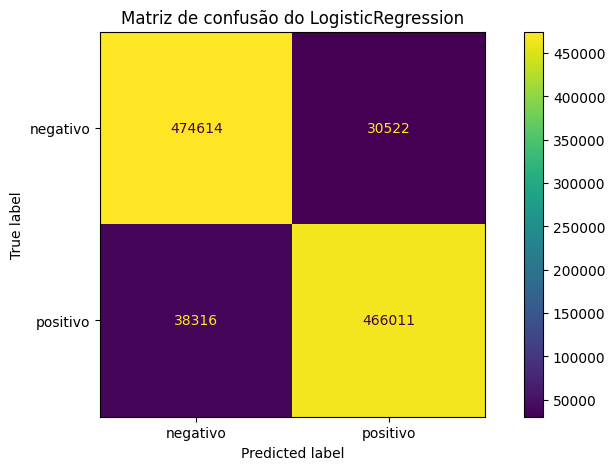

In [7]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

target_names = ["negativo", "positivo"]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Matriz de confusão do {clf.__class__.__name__}"
)

palavras mais relevantes por classe
        positivas   negativas
0           great  management
1            good        lack
2            work        dont
3        benefits        poor
4        flexible       hours
5            nice         low
6   opportunities   difficult
7        friendly      little
8       excellent        hard
9           learn    managers
10         decent        cons
11        company         pay
12           best         bad
13           easy        does
14    opportunity       times
15        amazing      doesnt
16    environment        need
17            fun     limited
18           pros        slow
19            job     balance


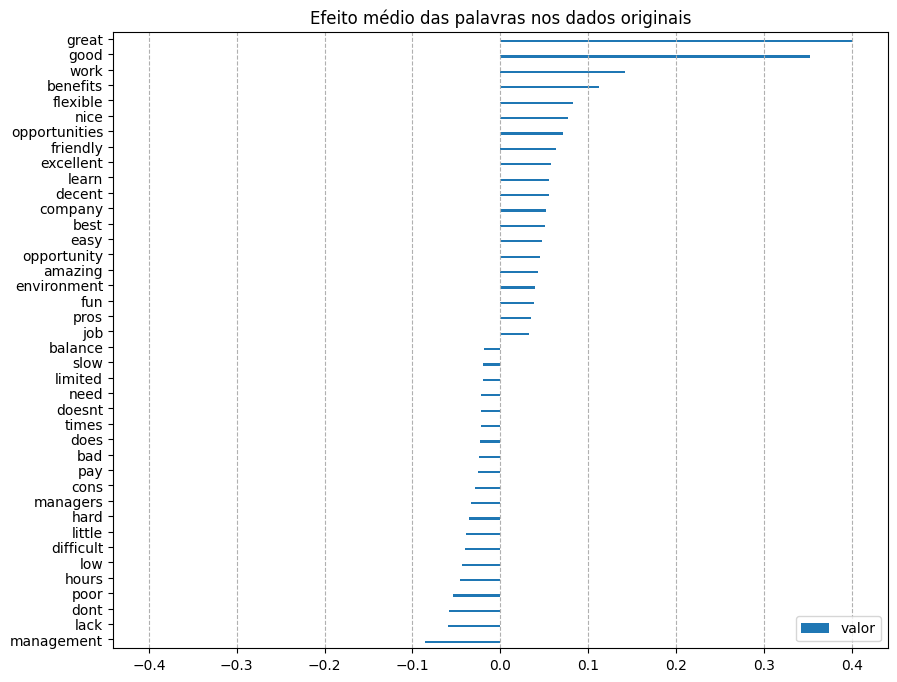

In [8]:
import numpy as np
import pandas as pd

def plot_feature_effects():
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    iordenados = np.argsort(average_feature_effects[0])
    fnames = feature_names[iordenados]
    average_feature_effects[0] = average_feature_effects[0][iordenados]
    iordenados = np.argsort(average_feature_effects[0])
    positivos10 = iordenados[-20:][::-1]
    negativos10 = iordenados[:20]
    
    top = pd.DataFrame()
    top["positivas"] = fnames[positivos10]
    top["negativas"] = fnames[negativos10]
    
    top_indices = np.concatenate((positivos10,negativos10), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = fnames[top_indices]

    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    largest = np.max(np.abs(average_feature_effects))*1.1
    ax.set_xlim(-largest,largest)
    ax.grid(True, "both", "x", linestyle="--")
    ax.barh(
        y_locs + -1 * bar_size,
        average_feature_effects[0, top_indices],
        height=bar_size,
        label="valor",
    )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("palavras mais relevantes por classe")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Efeito médio das palavras nos dados originais")

### Teste VADER

0.8308100445484381


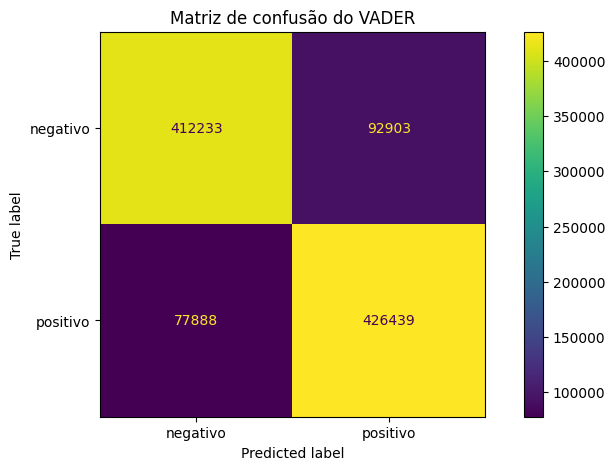

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

sia = SentimentIntensityAnalyzer()
def classify(txt):
    res = sia.polarity_scores(txt)["compound"]
    return -1 if res < 0.6 else 1

other_y = test_df["text"].map(classify)

print(accuracy_score(other_y, y_test))

target_names = ["negativo", "positivo"]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, other_y, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Matriz de confusão do VADER"
)

### Outros classificadores

In [10]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

from time import time

classificadores = {
    "Regressão Logística": LogisticRegression(),
    "Descida Estocástica (SVM)": SGDClassifier(loss="hinge", tol=1e-4, random_state=42),
    "Descida Estocástica (Logística)": SGDClassifier(loss="log_loss", tol=1e-4, random_state=42),
    "Descida Estocástica (Perceptron)": SGDClassifier(loss="perceptron", tol=1e-4, random_state=42),
    "SVM Linear (C=6*10^-6)": make_pipeline(StandardScaler(with_mean=False), LinearSVC(C=6e-6, random_state=42)),
}

print("== acurácia dos classificadores ==")
for nome, clf in classificadores.items():
    now = time()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"{nome:35} t={time()-now:<10.6} acc={score:<10.6}")

== acurácia dos classificadores ==
Regressão Logística                 t=10.0216    acc=0.931807  
Descida Estocástica (SVM)           t=6.83327    acc=0.921514  
Descida Estocástica (Logística)     t=8.87409    acc=0.912391  
Descida Estocástica (Perceptron)    t=5.36019    acc=0.903658  
SVM Linear (C=6*10^-6)              t=27.4127    acc=0.930964  


# Demonstração

In [11]:
def classify(txt):
    normalized = normaliza(txt)
    vetor = vectorizer.transform([txt])
    return {-1: "negativo", 1: "positivo"}[clf.predict(vetor)[0]]

reviews = [ 
    # positivos
    "While the workload can be overwhelming at times, the team is always willing to step in and help. I’ve had moments of frustration, but overall, the experience has been rewarding.",
    "There have been some challenging projects that pushed me to my limits, but I’ve gained invaluable skills in the process. It’s not always easy, but I can see the long-term benefits.",
    "The company has its flaws, like occasional communication breakdowns, but the leadership genuinely cares about improvement. The positives definitely outweigh the negatives in the long run.",
    "Although the initial training was lacking, I’ve managed to find my way and now feel confident in my role. It took some time, but I’m glad I stuck it out.",
    "The job can be stressful, especially during peak seasons, but the camaraderie among colleagues makes it worthwhile. I’ve considered leaving, but the support system here is hard to beat.",
    
    # negativos
    "The benefits package is decent, but the lack of transparency from management often leaves me feeling uncertain. While I appreciate some aspects, the overall experience has been disappointing.",
    "There are opportunities for growth, but they often come with a heavy workload and little recognition. I’ve learned a lot, but I’m not sure if it’s worth the constant stress.",
    "The work environment is generally positive, but there’s a significant disconnect between departments. This causes unnecessary friction, making it difficult to fully enjoy my job.",
    "The company offers some flexibility, but the lack of clear direction often leads to confusion. I appreciate the autonomy, but the disorganization is starting to wear on me.",
    "While the salary is competitive, the work-life balance is almost non-existent. The job offers some perks, but the long hours are beginning to take a toll on my personal life."
]

for string in reviews:
    print(f'"{string}": {classify(string)}')

"While the workload can be overwhelming at times, the team is always willing to step in and help. I’ve had moments of frustration, but overall, the experience has been rewarding.": negativo
"There have been some challenging projects that pushed me to my limits, but I’ve gained invaluable skills in the process. It’s not always easy, but I can see the long-term benefits.": positivo
"The company has its flaws, like occasional communication breakdowns, but the leadership genuinely cares about improvement. The positives definitely outweigh the negatives in the long run.": negativo
"Although the initial training was lacking, I’ve managed to find my way and now feel confident in my role. It took some time, but I’m glad I stuck it out.": negativo
"The job can be stressful, especially during peak seasons, but the camaraderie among colleagues makes it worthwhile. I’ve considered leaving, but the support system here is hard to beat.": positivo
"The benefits package is decent, but the lack of tran

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901889 entries, 0 to 9901888
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   pros    object
 1   cons    object
dtypes: object(2)
memory usage: 151.1+ MB
